<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [109]:
import io
import pickle
import random
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import (LSTM, BatchNormalization, CategoryEncoding, Dense,
                          Dropout, Embedding, Input, SimpleRNN,
                          TimeDistributed)
from keras.models import Model, Sequential
from keras.utils import to_categorical
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences  # se utilizará para padding

### Datos
Se utilizará un dataset ligero de spam de emails: https://www.kaggle.com/datasets/tapakah68/email-spam-classification

Primero descomprimimos el fichero y leemos los datos

In [110]:
!unzip -q email_spam.zip

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [111]:
dataframe_spam = pd.read_csv("email_spam.csv", encoding='latin-1')
# Reemplazar '\r' por un string vacío en todas las columnas
dataframe_spam = dataframe_spam.replace({'\r': ' ', '\n': ' ', "\?\?": ''}, regex=True)
dataframe_spam.head(300)

,title,text,type
0,the secrets to SUCCESS,"Hi James, Have you claim your complimentary g...",spam
1,You Earned 500 GCLoot Points,"alt_text Congratulations, you just earned 500...",not spam
2,Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420! ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello, Thank you for contacting the Virtual ...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal, Today's newsletter is Ja...",spam
...,...,...,...
79,Your application for the position of Child Pr...,"Dear Maryam, I would like to thank you fo...",not spam
80,Your Kilimall Account is Ready - Shopping Now!,"Dear Customer, Welcome to Kilimall, Thanks so...",not spam
81,Your Steam account: Access from new web or mob...,"Dear vladis163rus, Here is the Steam Guard cod...",not spam
82,Your uploaded document is rejected,View In Browser | Log in Skrill logo Mone...,not spam


In [112]:
dataframe_spam_title = dataframe_spam["title"]
dataframe_spam_text = dataframe_spam["text"]
dataframe_spam = pd.DataFrame({'Text': dataframe_spam_title + ' ' + dataframe_spam_text})
dataframe_spam.head(300)

,Text
0,"the secrets to SUCCESS Hi James, Have you cl..."
1,You Earned 500 GCLoot Points alt_text Congra...
2,Your GitHub launch code Here's your GitHub la...
3,[The Virtual Reward Center] Re: ** Clarificati...
4,"10-1 MLB Expert Inside, Plus Everything You Ne..."
...,...
79,Your application for the position of Child Pr...
80,Your Kilimall Account is Ready - Shopping Now!...
81,Your Steam account: Access from new web or mob...
82,Your uploaded document is rejected View In Bro...


### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [113]:
corpus = ' '.join(dataframe_spam['Text'])
print(corpus[:500])

 the secrets to SUCCESS Hi James,  Have you claim your complimentary gift yet?  I've compiled in here a special astrology gift that predicts everything about you in the future?  This is your enabler to take the correct actions now.  >> Click here to claim your copy now >>  Claim yours now, and thank me later.   Love, Heather  You Earned 500 GCLoot Points  alt_text Congratulations, you just earned 500   You completed the following offer:  View Points History To stop recieving notifications when y


In [114]:
# seleccionamos el tamaño de contexto
max_context_size = 150 # criterio a mano

In [115]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(corpus)

In [116]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

105

In [117]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [118]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in corpus]

In [119]:
tokenized_text[:1000]

[19,
 66,
 82,
 87,
 19,
 88,
 87,
 51,
 7,
 87,
 66,
 88,
 19,
 66,
 84,
 19,
 57,
 91,
 17,
 17,
 46,
 57,
 57,
 19,
 86,
 96,
 19,
 76,
 6,
 25,
 87,
 88,
 89,
 19,
 19,
 86,
 6,
 38,
 87,
 19,
 65,
 84,
 70,
 19,
 51,
 5,
 6,
 96,
 25,
 19,
 65,
 84,
 70,
 7,
 19,
 51,
 84,
 25,
 63,
 5,
 96,
 25,
 87,
 15,
 66,
 6,
 7,
 65,
 19,
 83,
 96,
 90,
 66,
 19,
 65,
 87,
 66,
 94,
 19,
 19,
 52,
 43,
 38,
 87,
 19,
 51,
 84,
 25,
 63,
 96,
 5,
 87,
 21,
 19,
 96,
 15,
 19,
 82,
 87,
 7,
 87,
 19,
 6,
 19,
 88,
 63,
 87,
 51,
 96,
 6,
 5,
 19,
 6,
 88,
 66,
 7,
 84,
 5,
 84,
 83,
 65,
 19,
 83,
 96,
 90,
 66,
 19,
 66,
 82,
 6,
 66,
 19,
 63,
 7,
 87,
 21,
 96,
 51,
 66,
 88,
 19,
 87,
 38,
 87,
 7,
 65,
 66,
 82,
 96,
 15,
 83,
 19,
 6,
 26,
 84,
 70,
 66,
 19,
 65,
 84,
 70,
 19,
 96,
 15,
 19,
 66,
 82,
 87,
 19,
 90,
 70,
 66,
 70,
 7,
 87,
 94,
 19,
 19,
 47,
 82,
 96,
 88,
 19,
 96,
 88,
 19,
 65,
 84,
 70,
 7,
 19,
 87,
 15,
 6,
 26,
 5,
 87,
 7,
 19,
 66,
 84,
 19,
 66,
 6,
 61,
 8

### Organizando y estructurando el dataset

In [120]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.2
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [121]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [122]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [123]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [124]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [125]:
X.shape

(59635, 150)

In [126]:
X[0,:10]

array([19, 66, 82, 87, 19, 88, 87, 51,  7, 87])

In [127]:
y[0,:10]

array([66, 82, 87, 19, 88, 87, 51,  7, 87, 66])

In [128]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

Para el el desafío, añadimos una capa mas de SimplRNN para ver cómo se comporta

In [129]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(250, return_sequences=True, dropout=0.1, recurrent_dropout=0.2))
model.add(SimpleRNN(250, return_sequences=True, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

c:\Users\Lorda\Source\Repos\CEIA\len-nat\.env\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, None, 105)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, None, 250)      │        89,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, None, 250)      │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 105)      │        26,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,605 (939.86 KB)

 Trainable params: 240,605 (939.86 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [130]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("char_my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [131]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 3.3217
 mean perplexity: 14.198404226643863 

Saved new model!
233/233 ━━━━━━━━━━━━━━━━━━━━ 92s 383ms/step - loss: 3.3203
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 2.4848
 mean perplexity: 12.259701969592728 

Saved new model!
233/233 ━━━━━━━━━━━━━━━━━━━━ 87s 374ms/step - loss: 2.4845
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 2.2428
 mean perplexity: 11.594906192103503 

Saved new model!
233/233 ━━━━━━━━━━━━━━━━━━━━ 87s 375ms/step - loss: 2.2426
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 2.0869
 mean perplexity: 10.709891157372345 

Saved new model!
233/233 ━━━━━━━━━━━━━━━━━━━━ 89s 381ms/step - loss: 2.0868
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 1.9755
 mean perplexity: 10.844710796356145 

233/233 ━━━━━━━━━━━━━━━━━━━━ 88s 377ms/step - loss: 1.9754
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 1.8921
 mean perplexity: 10.8292721

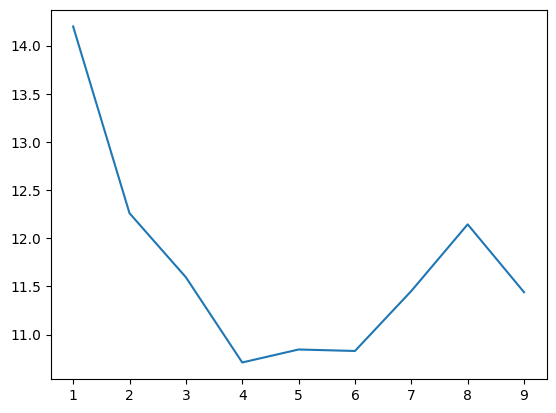

In [132]:
# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

Podemos observar que la perplexity del modelo no aumenta demasiado una vez se detiene el entrenamiento, por lo que decidimos quedarnos con la epoca 9 a pesar de que hay otras con mejor perplejidad.

In [133]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('char_my_model.keras')


### Predicción del próximo caracter

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [134]:
def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Keyboard interruption in main thread... closing s

Se puede comprobar en el "tester" del modelo su capacidad para completar palabras correctamente, pero una vez pasa a la siguiente palabra tiende a entrar en bucle en poco tiempo

### Generación de secuencias

In [135]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [137]:
input_text='the key to succ'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'the key to success to the in the surved to re'

###  Beam search y muestreo aleatorio

In [138]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [139]:
# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [155]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="you have receiv",temp=1,mode='sto')
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

you have received your program wit.
you have received your program with
you have received your program will
you have received your program will
you have received your program wilk
you have received your program with
you have received your program with
you have received your program will
you have received your program will
you have received your program will


In [156]:
salidas = beam_search(model,num_beams=10,num_words=20,input="you have receiv",temp=0.33,mode='sto')
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

you have receive your account for y
you have receive your account for a
you have receive your account for y
you have receive your account for y
you have receive your account for y
you have receive your account for y
you have receive your account for a
you have receive your account for y
you have receive your account for y
you have receive your account for y


In [161]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="there are some questi",temp=1,mode='sto')
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

there are some question with you have to 
there are some question with you have atu
there are some question with you have a m
there are some question with you have and
there are some question with you have at 
there are some question with you have and
there are some question with you have bal
there are some question with you have and
there are some question with you have and
there are some question with you have ano


In [158]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="there are some questi",temp=0.33,mode='sto')
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

there are some questions to your project 
there are some questions to your projects
there are some questions to your project 
there are some questions to your projects
there are some questions to your projecti
there are some questions to your project 
there are some questions to your project 
there are some questions to your projects
there are some questions to your project 
there are some questions to your project 


Se comprueba en estas pruebas que el valor de tempratura influye directamente sobre la variabilidad de la salida generada, haciendo que a tempraturas más frias el modelo tienda a devolver siempre la misma salida

In [160]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="Dear colleag",temp=1,mode='det')
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

Dear colleage company logo Custo
Dear colleage.                  
Dear colleage company logo Casto
Dear colleage company logo Servi
Dear colleage company logo Casti
Dear colleage company logo Compa
Dear colleage company logo Custi
Dear colleage company logo Call 
Dear colleage company logo Caste
Dear colleage company logo Conte


El modo determinista bloquea parte de la aleatoriedad de la salida, devolviendo siempre el mismo conjunto de resultados sin importar las veces que lo ejecutemos. Esto no ocurre en el modo estocástico, el cual devuelve valores distintos cada vez que se ejecuta el mismo código.

### Conclusiones
En este desafío hemos comprobado la capacidad de los modelos de lenguaje de caracteres para analizar una secuencia dada y ser capaz de completar la palabra incompleta. Sin embargo, se vuelve muy inestable a la hora de predecir la continuación de la frase, por lo que en estos casos conviene el uso de modelos de lenguaje especializados en palabras.

Es muy notable la diferencia entre los recursos necesarios para entrenar una modelo centrado en caracteres frente al de palabras. El segundo caso requiere un mayor volumen de datos, hiperparámetros y tiempo de entrenamiento, suponiendo un gran reto para aquellos desarrolladores que no posean suficiente capacidad de hardware